In [16]:
!nvidia-smi

Thu Oct 28 12:00:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   36C    P8    27W / 300W |   6452MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:2E:00.0 Off |                  Off |
| 30%   

In [46]:
from numba import jit
import cupy as cp
from cupyx import scatter_add
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
import vtk
import pyvista as pv
cp.cuda.Device(2).use()

@jit('void(int64[:,:], float64[:],float64[:])',nopython=True)
def asign_birth_node(elements,element_birth,node_birth):
    for i in range(0,elements.shape[0]):
        element = elements[i]
        birth = element_birth[i]
        if birth < 0:
            continue
        for j in range(0,8):
            node = element[j]
            if (node_birth[node] > birth or node_birth[node] < 0):
                node_birth[node] = birth

@jit('void(float64[:,:],int64[:,:],float64[:],float64[:],int64[:])',nopython=True)
def renum_ele_node(nodes,elements,node_birth,element_birth,element_mat):
    n_id_sort = np.argsort(node_birth)
    n_id_map = np.zeros_like(n_id_sort)
    nodes = nodes[n_id_sort]
    node_birth = node_birth[n_id_sort]
    for i in range(0,n_id_sort.shape[0]):
        n_id_map[n_id_sort[i]] = i
    for i in range(0,elements.shape[0]):
        for j in range(0,8):
            elements[i,j] = n_id_map[elements[i,j]]
    e_id_sort = np.argsort(element_birth)
    elements = elements[e_id_sort]
    element_mat = element_mat[e_id_sort]
    element_birth = element_birth[e_id_sort]


@jit('void(int64[:,:], int64[:,:],int64[:],int64[:],int64[:])',nopython=True,)
def createElElConn(elements,connElEl,connVec,connVecIndx,conn_to_el_Vec):
    ele_num = elements.shape[0]
    for i in range(0,ele_num):
        element = elements[i]
        for j in range(0,8):
            node = element[j]
            lower_bound = np.searchsorted(connVec,node)
            higher_bound = np.searchsorted(connVec,node,side='right')
            for k in range(lower_bound,higher_bound):
                nodeEleK = connVecIndx[k]
                if i != conn_to_el_Vec[nodeEleK]:
                    for l in range(0,100):
                        if connElEl[i,l] == conn_to_el_Vec[nodeEleK]:
                            break
                        if connElEl[i,l] == -1:
                            connElEl[i,l] = conn_to_el_Vec[nodeEleK]
                            break

@jit('void(int64[:,:], int64[:,:],int64[:,:])',nopython=True,)
def createConnSurf(elements,connElEl,connect_surf):
    for i in range (0,elements.shape[0]):
        element = elements[i]
        for j in connElEl[i,:]:
            if j == -1:
                break
            if (j == i):
                continue
            s_element = elements[j]
            ind = np.zeros(4)
            num = 0
            for k in range(0,8):
                for l in range(0,8):
                    if element[k] == s_element[l]:
                        ind[num] = k
                        num = num + 1
                        break
            if ind[0] == 0 and ind[1] == 1 and ind[2] == 2 and ind[3] == 3:
                connect_surf[i][1] = j
            if ind[0] == 0 and ind[1] == 1 and ind[2] == 4 and ind[3] == 5:
                connect_surf[i][2] = j
            if ind[0] == 0 and ind[1] == 3 and ind[2] == 4 and ind[3] == 7:
                connect_surf[i][4] = j

                
        for j in connElEl[i,:]:
            if j == -1:
                break
            if (j == i):
                continue
            s_element = elements[j]
            ind = np.zeros(4)
            num = 0
            for k in range(0,8):
                for l in range(0,8):
                    if element[k] == s_element[l]:
                        ind[num] = k
                        num = num + 1
                        break
            if ind[0] == 4 and ind[1] == 5 and ind[2] == 6 and ind[3] == 7:
                connect_surf[i][0] = j
            if ind[0] == 2 and ind[1] == 3 and ind[2] == 6 and ind[3] == 7:
                connect_surf[i][3] = j
            if ind[0] == 1 and ind[1] == 2 and ind[2] == 5 and ind[3] == 6:
                connect_surf[i][5] = j
                
@jit(nopython=True)
def createSurf(elements,nodes,element_birth,connect_surf,surfaces,surface_birth,surface_xy,surface_flux,surface_contact):
    surface_num = 0
    index = np.array([[4,5,6,7],[0,1,2,3],[0,1,5,4],[3,2,6,7],[0,3,7,4],[1,2,6,5]])
    for i in range (0,elements.shape[0]):
        element = elements[i]
        birth_current = element_birth[i]
        for j in range(0,6):
            if connect_surf[i][j] == -1:
                birth_neighbor = 1e10
            else:
                birth_neighbor = element_birth[connect_surf[i][j]]
            if birth_neighbor > birth_current:
                surfaces[surface_num] = element[index[j]]
                surface_birth[surface_num,0] = birth_current
                surface_birth[surface_num,1] = birth_neighbor
                if abs(nodes[element[index[j]]][0,2]-nodes[element[index[j]]][1,2])<1e-2 and abs(nodes[element[index[j]]][1,2]-nodes[element[index[j]]][2,2])<1e-2:
                    surface_xy[surface_num] = 1
                surface_num += 1

    surfaces = surfaces[0:surface_num]
    surface_birth = surface_birth[0:surface_num]
    surface_xy = surface_xy[0:surface_num]
    
    ########################################
    height = -nodes[:,2].min()
    for i in range(0,surface_num):
        if max(nodes[surfaces[i,:]][:,2])>-height:
            surface_flux[i] = 1
    
    for i in range(0,surface_num):
        if max(nodes[surfaces[i,:]][:,2])==-height and min(nodes[surfaces[i,:]][:,2])==-height:
            surface_contact[i] = 1
    
    return surface_num



def load_toolpath(filename = 'toolpath.crs'):
    toolpath_raw=pd.read_table(filename, delimiter=r"\s+",header=None, names=['time','x','y','z','state'])
    return toolpath_raw.to_numpy()

def get_toolpath(toolpath_raw,dt,endtime):
    time = np.arange(0,endtime,dt)
    x = np.interp(time,toolpath_raw[:,0],toolpath_raw[:,1])
    y = np.interp(time,toolpath_raw[:,0],toolpath_raw[:,2])
    z = np.interp(time,toolpath_raw[:,0],toolpath_raw[:,3])

    laser_state = np.interp(time,toolpath_raw[:,0],toolpath_raw[:,4])
    l = np.zeros_like(laser_state)
    for i in range(1,laser_state.shape[0]):
        if laser_state[i] == 1:
            l[i] = 1
        if laser_state[i]>laser_state[i-1]:
            l[i] = 1
    laser_state = l
    laser_state = laser_state* (time<=toolpath_raw[-1,0]) #if time >= toolpath time, stop laser
    
    return np.array([x,y,z,laser_state]).transpose()

def shape_fnc_element(parCoord):
    chsi = parCoord[0]
    eta = parCoord[1]
    zeta = parCoord[2]
    N =  0.125 * np.stack([(1.0 - chsi)*(1.0 - eta)*(1.0 - zeta),(1.0 + chsi)*(1.0 - eta)*(1.0 - zeta),
                           (1.0 + chsi)*(1.0 + eta)*(1.0 - zeta), (1.0 - chsi)*(1.0 + eta)*(1.0 - zeta),
                           (1.0 - chsi)*(1.0 - eta)*(1.0 + zeta), (1.0 + chsi)*(1.0 - eta)*(1.0 + zeta),
                           (1.0 + chsi)*(1.0 + eta)*(1.0 + zeta), (1.0 - chsi)*(1.0 + eta)*(1.0 + zeta)])
    return N
    
def derivate_shape_fnc_element(parCoord):
    oneMinusChsi = 1.0 - parCoord[0]
    onePlusChsi  = 1.0 + parCoord[0]
    oneMinusEta  = 1.0 - parCoord[1]
    onePlusEta   = 1.0 + parCoord[1]
    oneMinusZeta = 1.0 - parCoord[2]
    onePlusZeta  = 1.0 + parCoord[2]
    B = 0.1250 * np.array([[-oneMinusEta * oneMinusZeta, oneMinusEta * oneMinusZeta, 
                                onePlusEta * oneMinusZeta, -onePlusEta * oneMinusZeta, 
                                -oneMinusEta * onePlusZeta, oneMinusEta * onePlusZeta, 
                                onePlusEta * onePlusZeta, -onePlusEta * onePlusZeta],
                              [-oneMinusChsi * oneMinusZeta, -onePlusChsi * oneMinusZeta, 
                               onePlusChsi * oneMinusZeta, oneMinusChsi * oneMinusZeta, 
                               -oneMinusChsi * onePlusZeta, -onePlusChsi * onePlusZeta, 
                               onePlusChsi * onePlusZeta, oneMinusChsi * onePlusZeta],
                               [-oneMinusChsi * oneMinusEta, -onePlusChsi * oneMinusEta, 
                                -onePlusChsi * onePlusEta, -oneMinusChsi * onePlusEta, 
                                oneMinusChsi * oneMinusEta, onePlusChsi * oneMinusEta, 
                                onePlusChsi * onePlusEta, oneMinusChsi * onePlusEta]])
    return B

def shape_fnc_surface(parCoord):
    N = np.zeros((4))
    chsi = parCoord[0]
    eta  = parCoord[1]
    N = 0.25 * np.array([(1-chsi)*(1-eta), (1+chsi)*(1-eta), (1+chsi)*(1+eta), (1-chsi)*(1+eta)])
    return N


def derivate_shape_fnc_surface(parCoord):
    oneMinusChsi = 1.0 - parCoord[0]
    onePlusChsi  = 1.0 + parCoord[0]
    oneMinusEta  = 1.0 - parCoord[1]
    onePlusEta   = 1.0 + parCoord[1]
    B = 0.25 * np.array([[-oneMinusEta, oneMinusEta, onePlusEta, -onePlusEta], 
                         [-oneMinusChsi, -onePlusChsi, onePlusChsi, oneMinusChsi]])
    return B


In [115]:
class domain_mgr():
    def __init__(self,filename):
        self.filename = filename
        parCoords_element = np.array([[-1.0,-1.0,-1.0],[1.0,-1.0,-1.0],[1.0, 1.0,-1.0],[-1.0, 1.0,-1.0],
                                      [-1.0,-1.0,1.0],[1.0,-1.0, 1.0], [ 1.0,1.0,1.0],[-1.0, 1.0,1.0]]) * 0.5773502692
        parCoords_surface = np.array([[-1.0,-1.0],[-1.0, 1.0],[1.0,-1.0],[1.0,1.0]])* 0.5773502692
        self.Nip_ele = cp.array([shape_fnc_element(parCoord) for parCoord in parCoords_element])[:,:,np.newaxis]
        self.Nip_ele = cp.array([shape_fnc_element(parCoord) for parCoord in parCoords_element])
        self.Bip_ele = cp.array([derivate_shape_fnc_element(parCoord) for parCoord in parCoords_element])
        self.Nip_sur = cp.array([shape_fnc_surface(parCoord) for parCoord in parCoords_surface])
        self.Bip_sur = cp.array([derivate_shape_fnc_surface(parCoord) for parCoord in parCoords_surface])
        
        self.init_domain()
        self.current_time = 0
        self.get_ele_J()
        self.get_surf_ip_pos_and_J()
        
    def load_file(self):
        nodes = []
        node_sets = {}
        elements = []
        element_mat = []
        mat_thermal = []
        thermal_TD = {}
        birth_list_element = []
        birth_list_node = []
        filename = self.filename
        with open(filename) as f:
            line = next(f)
            while True: 
                if not line.split():
                    line = next(f)
                    continue

                # option *Node
                elif line.split()[0] == '*NODE':
                    first = True
                    while True:
                        line = next(f)
                        if line[0] == '*':
                            break
                        if line[0] == '$':
                            continue
                        text = line.split()
                        if first:
                            node_base = int(text[0])
                            first = False
                        nodes.append([float(text[1]),float(text[2]),float(text[3])])

        #         # option *SET_NODE_LIST
                elif  line.split()[0] == '*SET_NODE_LIST':
                    line = next(f)
                    line = next(f)
                    key = int(line.split()[0])
                    node_list = []
                    while True:
                        line = next(f)
                        if line[0] == '*':
                            break
                        if line[0] == '$':
                            continue
                        for text in line.split():
                            node_list.append(int(text)-node_base)
                    node_sets[key] = node_list

                # option **ELEMENT_SOLID
                elif line.split()[0] == '*ELEMENT_SOLID':
                    first = True
                    while True:
                        line = next(f)
                        if line[0] == '*':
                            break
                        if line[0] == '$':
                            continue
                        text = line.split()
                        if first:
                            element_base = int(text[0])
                            first = False

                        elements.append([int(text[2])-node_base, int(text[3])-node_base, int(text[4])-node_base, int(text[5])-node_base,
                                         int(text[6])-node_base, int(text[7])-node_base, int(text[8])-node_base, int(text[9])-node_base])
                        element_mat.append(int(text[1]))       

                elif line.split()[0] == '*END':
                    birth_list_node = [-1 for _ in range(len(nodes))]
                    birth_list_element = [0.0]*len(elements)
                    break

                elif line.split()[0] == '*TOOL_FILE':
                    line = next(f)
                    self.toolpath_file = line.split()[0]
                    line = next(f)

                elif line.split()[0] == '*PARAMETER':
                    line = next(f)
                    if line.split()[0] == 'Rboltz':
                        boltz = float(line.split()[1])
                    if line.split()[0] == 'Rambient':
                        self.ambient = float(line.split()[1])
                    if line.split()[0] == 'Rabszero':
                        abszero = float(line.split()[1])
                    line = next(f)

                elif line.split()[0] == '*GAUSS_LASER':
                    line = next(f)
                    text = line.split()
                    self.q_in = float(text[0])*float(text[2])
                    self.r_beam = float(text[1])

                elif line.split()[0] == '*CONTROL_TIMESTEP':
                    line = next(f)
                    line = next(f)
                    self.dt = float(line.split()[0])

                elif line.split()[0] == '*CONTROL_TERMINATION':
                    line = next(f)
                    line = next(f)
                    self.end_time = float(line.split()[0])

                elif line.split()[0] == '*DATABASE_NODOUT':
                    line = next(f)
                    line = next(f)
                    output_step = float(line.split()[0])
                
                elif line.split()[0] == '*LOAD_NODE_SET':
                    while True:
                        line = next(f)
                        if line[0] == '*':
                            break
                        if line.split()[1] == 'Radiation' or line.split()[1] == 'radiation':
                            line = next(f)
                            self.h_rad = float(line.split()[2])
                        if line.split()[1] == 'convection' or line.split()[1] == 'Convection' :
                            line = next(f)
                            self.h_conv = float(line.split()[2])

                elif line.split()[0] == '*MAT_THERMAL_ISOTROPIC':
                    line = next(f)
                    line = next(f)
                    text1 = line.split()
                    line = next(f)
                    text2 = line.split()
                    mat_thermal.append([int(text1[0]), # mat ID
                                        float(text1[1]), # density
                                        float(text1[2]), # solidus
                                        float(text1[3]), # liquidus
                                        float(text1[4]), # latent heat
                                        float(text2[0]), # heat capacity
                                        float(text2[1]),]) # thermal conductivity

                elif line.split()[0] == '*MAT_THERMAL_ISOTROPIC_TD':
                    line = next(f)
                    line = next(f)
                    text1 = line.split()
                    mat_thermal.append([int(text1[0]), # mat ID
                                        float(text1[1]), # density
                                        float(text1[2]), # solidus
                                        float(text1[3]), # liquidus
                                        float(text1[4]), # latent heat
                                        -1, # heat capacity, TD
                                        -1,]) # thermal conductivity, TD '
                    line = next(f)
                    Cp = np.loadtxt(line.split()[0])
                    line = next(f)
                    cond = np.loadtxt(line.split()[0])
                    thermal_TD[int(text1[0])] = [Cp,cond]


                else:
                    line = next(f)

        with open(filename) as f:
                while True:
                    line = next(f)
                    if not line.split():
                        continue
                    if line.split()[0] == '*DEFINE_CURVE':
                        while True:
                            line = next(f)
                            if line[0] == '*':
                                break
                            if line[0] == '$':
                                continue
                            text = line.split()
                            birth_list_element[int(float(text[1]))-element_base] = float(text[0])
                    if line.split()[0] == '*END':
                        break

        nodes = np.array(nodes)
        elements = np.array(elements)
        element_mat = np.array(element_mat)
        element_birth = np.array(birth_list_element)
        node_birth = np.array(birth_list_node,dtype=np.float64)
        asign_birth_node(elements,element_birth,node_birth)
        
        
        n_id_sort = np.argsort(node_birth)
        n_id_map = np.zeros_like(n_id_sort)
        nodes = nodes[n_id_sort]
        node_birth = node_birth[n_id_sort]
        for i in range(0,n_id_sort.shape[0]):
            n_id_map[n_id_sort[i]] = i
        for i in range(0,elements.shape[0]):
            for j in range(0,8):
                elements[i,j] = n_id_map[elements[i,j]]
        e_id_sort = np.argsort(element_birth)
        elements = elements[e_id_sort]
        element_mat = element_mat[e_id_sort]
        element_birth = element_birth[e_id_sort]
        
        
        
        self.nodes = cp.asarray(nodes)
        self.nN = self.nodes.shape[0]
        self.node_birth = node_birth
        self.elements = elements
        self.nE = self.elements.shape[0]
        self.element_birth = element_birth
#         ind = (self.nodes[self.elements,2]).argsort()
#         elements_order = [self.elements[i,ind[i]] for i in range(0,ind.shape[0])]
#         self.elements_order = cp.array(elements_order)
        self.element_mat = element_mat
        
        self.mat_thermal = mat_thermal
        self.thermal_TD = thermal_TD
        
    def init_domain(self):
        # reading input files
        start = time.time()
        self.load_file()
        end = time.time()
        print("Time of reading input files: {}".format(end-start))
        
        # calculating critical timestep
        self.defaultFac = 0.75
        start = time.time()
        self.get_timestep()
        end = time.time()
        print("Time of calculating critical timestep: {}".format(end-start))

        # reading and interpolating toolpath
        start = time.time()
        toolpath_raw = load_toolpath(filename = self.toolpath_file)
        toolpath = get_toolpath(toolpath_raw,self.dt,self.end_time)
        end = time.time()
        print("Time of reading and interpolating toolpath: {}".format(end-start))
        self.toolpath = cp.asarray(toolpath)

        print("Number of nodes: {}".format(len(self.nodes)))
        print("Number of elements: {}".format(len(self.elements)))
        print("Number of time-steps: {}".format(len(self.toolpath)))
                
        # generating surface
        start = time.time()
        self.generate_surf()
        end = time.time()
        print("Time of generating surface: {}".format(end-start))
        
    def generate_surf(self):
        elements = self.elements
        nodes = self.nodes.get()
        element_birth = self.element_birth
        
        ele_num = elements.shape[0]
        connElEl = -np.ones([ele_num,100],dtype=np.int64)
        connVec = elements.flatten()
        conn_to_el_Vec = np.arange(0,ele_num)[:,np.newaxis].repeat(8,axis=1).flatten()
        connVecIndx = np.arange(0,ele_num*8)
        connVecIndx  = connVecIndx[np.argsort(connVec)]
        connVec = connVec[connVecIndx]

        # find neighbor eles
        createElElConn(elements,connElEl,connVec,connVecIndx,conn_to_el_Vec)

        # surface connection
        connect_surf = -np.ones([elements.shape[0],6],dtype=np.int64)
        createConnSurf(elements,connElEl,connect_surf)

        # creat surface
        surfaces = np.zeros([elements.shape[0]*6,4],dtype=np.int64)
        surface_birth = np.zeros([elements.shape[0]*6,2])
        surface_xy = np.zeros([elements.shape[0]*6,1],dtype=np.int64)
        surface_flux = np.zeros([elements.shape[0]*6,1],dtype=np.int64)
        surface_contact = np.zeros([elements.shape[0]*6,1],dtype=np.int64)

        surface_num = createSurf(elements,nodes,element_birth,connect_surf,surfaces,surface_birth,surface_xy,surface_flux,surface_contact)
        self.surface = surfaces[0:surface_num]
        self.surface_birth = surface_birth[0:surface_num]
        self.surface_xy = cp.array(surface_xy[0:surface_num])
        self.surface_flux = cp.array(surface_flux[0:surface_num])
        self.surface_contact = cp.array(surface_contact[0:surface_num])
                


    def update_birth(self):
        self.active_elements = self.element_birth<self.current_time
        self.active_nodes = self.node_birth<self.current_time
        self.active_surface = (self.surface_birth[:,0]<self.current_time)*(self.surface_birth[:,1]>self.current_time)
    
    def get_ele_J(self):
        nodes_pos = self.nodes[self.elements]
        Jac = cp.matmul(self.Bip_ele,nodes_pos[:,cp.newaxis,:,:].repeat(8,axis=1)) # J = B*x [B:8(nGP)*3(dim)*8(nN), x:nE*8*8*3]
        self.ele_detJac = cp.linalg.det(Jac)
        
        iJac = cp.linalg.inv(Jac) #inv J (nE*nGp*dim*dim)
        self.ele_gradN = cp.matmul(iJac,self.Bip_ele) # dN/dx = inv(J)*B
    
    def get_surf_ip_pos_and_J(self):
        self.surf_ip_pos = self.Nip_sur@self.nodes[self.surface]
        
        nodes_pos = self.nodes[self.surface]
        mapped_surf_nodes_pos = cp.zeros([nodes_pos.shape[0],4,2])
        u = nodes_pos[:,1,:] - nodes_pos[:,0,:]
        v = nodes_pos[:,2,:] - nodes_pos[:,1,:]
        w = nodes_pos[:,3,:] - nodes_pos[:,0,:]
        l1 = cp.linalg.norm(u,axis=1)
        l2 = cp.linalg.norm(v,axis=1)
        l4 = cp.linalg.norm(w,axis=1)
        cos12 = (u[:,0]*v[:,0] + u[:,1]*v[:,1] + u[:,2]*v[:,2])/(l1*l2)
        cos14 = (u[:,0]*w[:,0] + u[:,1]*w[:,1] + u[:,2]*w[:,2])/(l1*l4)
        sin12 = cp.sqrt(1.0 - cos12*cos12)
        sin14 = cp.sqrt(1.0 - cos14*cos14)
        mapped_surf_nodes_pos[:,1,0] = l1
        mapped_surf_nodes_pos[:,2,0] = l1 + l2*cos12
        mapped_surf_nodes_pos[:,2,1] = l2*sin12
        mapped_surf_nodes_pos[:,3,0] = l4*cos14
        mapped_surf_nodes_pos[:,3,1] = l4*sin14
        Jac = cp.matmul(self.Bip_sur,mapped_surf_nodes_pos[:,cp.newaxis,:,:].repeat(4,axis=1))
        self.surf_detJac = cp.linalg.det(Jac)

    def get_timestep(self):
        #element volume
        nodes_pos = self.nodes[self.elements]
        # J = B*x [B:8(nGP)*3(dim)*8(nN), x:nE*8*8*3]
        Jac = cp.matmul(self.Bip_ele,nodes_pos[:,np.newaxis,:,:].repeat(8,axis=1))
        ele_detJac = cp.linalg.det(Jac)
        ele_vol = ele_detJac.sum(axis=1)

        #surface area
        element_surface = self.elements[:,[[4,5,6,7],[0,1,2,3],[0,1,5,4],[3,2,6,7],[0,3,7,4],[1,2,6,5]]]
        surf_ip_pos = self.Nip_sur@self.nodes[element_surface]
        nodes_pos = self.nodes[element_surface]
        mapped_surf_nodes_pos = cp.zeros([nodes_pos.shape[0],6,4,2])
        u = nodes_pos[:,:,1,:] - nodes_pos[:,:,0,:]
        v = nodes_pos[:,:,2,:] - nodes_pos[:,:,1,:]
        w = nodes_pos[:,:,3,:] - nodes_pos[:,:,0,:]
        l1 = cp.linalg.norm(u,axis=2)
        l2 = cp.linalg.norm(v,axis=2)
        l4 = cp.linalg.norm(w,axis=2)
        cos12 = (u[:,:,0]*v[:,:,0] + u[:,:,1]*v[:,:,1] + u[:,:,2]*v[:,:,2])/(l1*l2)
        cos14 = (u[:,:,0]*w[:,:,0] + u[:,:,1]*w[:,:,1] + u[:,:,2]*w[:,:,2])/(l1*l4)
        sin12 = cp.sqrt(1.0 - cos12*cos12)
        sin14 = cp.sqrt(1.0 - cos14*cos14)
        mapped_surf_nodes_pos[:,:,1,0] = l1
        mapped_surf_nodes_pos[:,:,2,0] = l1 + l2*cos12
        mapped_surf_nodes_pos[:,:,2,1] = l2*sin12
        mapped_surf_nodes_pos[:,:,3,0] = l4*cos14
        mapped_surf_nodes_pos[:,:,3,1] = l4*sin14

        Jac = cp.matmul(self.Bip_sur,mapped_surf_nodes_pos[:,:,cp.newaxis,:,:].repeat(4,axis=2))
        surf_detJac = cp.linalg.det(Jac)
        ele_surf_area = surf_detJac.sum(axis=2)

        # critical time step
        ele_length = ele_vol/ele_surf_area.max(axis=1)
        for i in range(len(self.mat_thermal)):
            l = ele_length[self.element_mat==i+1].min()
            if self.mat_thermal[i][5] == -1:
                min_Cp = self.thermal_TD[i+1][0][:,1].min()
            else:
                min_Cp = self.mat_thermal[i][5]
            if self.mat_thermal[i][6] == -1:
                max_Cond = self.thermal_TD[i+1][1][:,1].min()
            else:
                max_Cond = self.mat_thermal[i][6]
            Rho = self.mat_thermal[i][1]
            dt = min_Cp*Rho/max_Cond*l**2/2.0 * self.defaultFac
            self.dt = min(self.dt,dt.item())



In [120]:
class heat_solve_mgr():
    def __init__(self,domain):
        ##### modification needed, from files
        self.domain = domain
        self.ambient = domain.ambient
        self.r_beam = domain.r_beam
        self.q_in = domain.q_in
        self.h_conv = domain.h_conv
        self.h_rad = domain.h_rad
        self.height = -domain.nodes[:,2].min()
        
        # initialization
        self.temperature = self.ambient*cp.ones(self.domain.nodes.shape[0])
        self.current_step = 0
        self.rhs = cp.zeros(self.domain.nN)
        self.m_vec = cp.zeros(self.domain.nN)
        self.density_Cp_Ip = cp.zeros([domain.nE,8])
        self.Cond_Ip = cp.zeros([domain.nE,8])
        self.melt_depth = 0
        
    def update_cp_cond(self):
        domain=self.domain
        elements = domain.elements
        temperature_nodes = self.temperature[elements]
        temperature_ip = (domain.Nip_ele[:,cp.newaxis,:]@temperature_nodes[:,cp.newaxis,:,cp.newaxis].repeat(8,axis=1))[:,:,0,0]
        
        self.density_Cp_Ip *= 0
        self.Cond_Ip *= 0
        
        ##### temp-dependent, modification needed, from files
        for i in range(0,len(domain.mat_thermal)):
            matID = domain.mat_thermal[i][0]
            mat = domain.element_mat == matID
            thetaIp = temperature_ip[domain.active_elements*mat]
            
            solidus = domain.mat_thermal[i][2]
            liquidus = domain.mat_thermal[i][3]
            latent = domain.mat_thermal[i][4]/(liquidus-solidus)
            density = domain.mat_thermal[i][1]
            
            self.density_Cp_Ip[domain.active_elements*mat] += density*latent*(thetaIp>solidus)*(thetaIp<liquidus)
            
            if domain.mat_thermal[i][5] == -1:
                temp_Cp = cp.asarray(domain.thermal_TD[matID][0][:,0])
                Cp = cp.asarray(domain.thermal_TD[matID][0][:,1])            
                self.density_Cp_Ip[domain.active_elements*mat] += density*cp.interp(thetaIp,temp_Cp,Cp)
            else:
                Cp = domain.mat_thermal[i][5]
                self.density_Cp_Ip[domain.active_elements*mat] += density*Cp
                
            
            if domain.mat_thermal[i][6] == -1:
                temp_Cond = cp.asarray(domain.thermal_TD[matID][1][:,0])
                Cond = cp.asarray(domain.thermal_TD[matID][1][:,1])
                self.Cond_Ip[domain.active_elements*mat] += cp.interp(thetaIp,temp_Cond,Cond)
            else:
                self.Cond_Ip[domain.active_elements*mat] += domain.mat_thermal[i][6]


   
    def update_mvec_stifness(self):
        nodes = self.domain.nodes
        elements = self.domain.elements[self.domain.active_elements]
        Bip_ele = self.domain.Bip_ele
        Nip_ele = self.domain.Nip_ele
        temperature_nodes = self.temperature[elements]
        
        detJac = self.domain.ele_detJac[self.domain.active_elements]
        density_Cp_Ip = self.density_Cp_Ip[self.domain.active_elements]
        mass = cp.sum((density_Cp_Ip * detJac)[:,:,cp.newaxis,cp.newaxis] 
                      * Nip_ele[:,:,cp.newaxis]@Nip_ele[:,cp.newaxis,:],axis=1)
        lump_mass= cp.sum(mass,axis=2)

        gradN = self.domain.ele_gradN[self.domain.active_elements]
        Cond_Ip = self.Cond_Ip[self.domain.active_elements]
        stiffness = cp.sum((Cond_Ip * detJac)[:,:,cp.newaxis,cp.newaxis] * gradN.transpose([0,1,3,2])@gradN,axis = 1)
        stiff_temp = stiffness@temperature_nodes[:,:,cp.newaxis]
        
        self.rhs *= 0
        self.m_vec *= 0

        scatter_add(self.rhs,elements.flatten(),-stiff_temp.flatten())
        scatter_add(self.m_vec,elements.flatten(),lump_mass.flatten())
        

    def update_fluxes(self):
        surface = self.domain.surface[self.domain.active_surface]
        nodes = self.domain.nodes
        Nip_sur = self.domain.Nip_sur
        Bip_sur = self.domain.Bip_sur
        surface_xy  = self.domain.surface_xy[self.domain.active_surface]
        surface_flux = self.domain.surface_flux[self.domain.active_surface]

        q_in = self.q_in
        h_conv =self.h_conv
        ambient = self.ambient
        h_rad = self.h_rad
        r_beam = self.r_beam
        laser_loc = self.laser_loc
        laser_state = self.laser_state
        
        ip_pos = self.domain.surf_ip_pos[self.domain.active_surface]
    
        r2 = cp.square(cp.linalg.norm(ip_pos-laser_loc,axis=2))
        qmov = 3.0 * q_in * laser_state /(cp.pi * r_beam**2)*cp.exp(-3.0 * r2 / (r_beam**2)) * surface_xy 

        temperature_nodes = self.temperature[surface]
        temperature_ip = Nip_sur@temperature_nodes[:,:,cp.newaxis]

        #############
        z_dis =  cp.clip((laser_loc[2] - ip_pos[:,:,2]),0,4.5)[:,:,cp.newaxis]
        qconv = -1 * (7e-5 - z_dis/4.5*6e-5) * (temperature_ip - ambient)
        qconv = qconv[:,:,0]*surface_flux
        
        qrad = -1 * 5.6704e-14 * h_rad * (temperature_ip**4 - ambient**4)
        qrad = qrad [:,:,0]*surface_flux
        
        #############
        h_contact = 1e-4
        qcontact = -1 * h_contact * (temperature_ip - ambient)
        qcontact = qcontact [:,:,0]*(1-surface_flux)

        detJac = self.domain.surf_detJac[self.domain.active_surface]
        q = ((qmov+qrad+qconv+qcontact)*detJac)[:,:,cp.newaxis].repeat(4,axis=2)*Nip_sur
        scatter_add(self.rhs,surface.flatten(),q.sum(axis=1).flatten())

    def time_integration(self):
        domain = self.domain
        self.current_step += 1
        domain.current_time += domain.dt
        domain.update_birth()

        self.update_cp_cond()
        self.update_mvec_stifness()

        self.laser_loc = domain.toolpath[self.current_step,0:3]
        self.laser_state = domain.toolpath[self.current_step,3]
        self.update_fluxes()

        self.temperature[domain.active_nodes] += domain.dt*self.rhs[domain.active_nodes]/self.m_vec[domain.active_nodes]
        # modification required
#         self.temperature[cp.where(domain.nodes[:,2]==-self.height)]=self.ambient
        
    
    def calculate_melt(self):
        domain = self.domain
        elements = domain.elements_order[domain.active_elements]
        temperature_ele_nodes = self.temperature[elements]

        temperature_ele_max = temperature_ele_nodes.max(axis = 1)
        solidus = 1533.15
        elements = elements[temperature_ele_nodes[:,4:8].max(axis=1)>=solidus]
        temperature_ele_nodes = self.temperature[elements]
        if elements.shape[0]>0:
            ele_nodes_pos = domain.nodes[elements]
            melt_topz = ele_nodes_pos[:,4,2].max()

        elements = elements[temperature_ele_nodes[:,0:4].max(axis=1)<=solidus]
        temperature_ele_nodes = self.temperature[elements]
        
        self.melt_depth = 0
        if elements.shape[0]>0:
            
            ele_nodes_pos = domain.nodes[elements]


            temperature_ele_top = temperature_ele_nodes[:,4:8].max(axis=1)
            temperature_ele_bot = temperature_ele_nodes[:,0:4].max(axis=1)
            z_top = ele_nodes_pos[:,4,2]
            z_bot = ele_nodes_pos[:,0,2]
            melt_botz =  z_bot + (z_top - z_bot) * (solidus - temperature_ele_bot) / (temperature_ele_top - temperature_ele_bot);

            self.melt_depth = melt_topz - melt_botz.min()

In [121]:
filename = 'inputs/thinwall_v2.k'
domain = domain_mgr(filename)
heat_solver = heat_solve_mgr(domain)

Time of reading input files: 0.23028254508972168
Time of calculating critical timestep: 0.009422063827514648
Time of reading and interpolating toolpath: 0.0600581169128418
Number of nodes: 23572
Number of elements: 17400
Number of time-steps: 119710
Time of generating surface: 0.10750341415405273


In [122]:
%%time
endtime = domain.end_time
temp = []
node_list = np.where((domain.nodes[:,1]==-1)*(domain.nodes[:,0]==-9.75)*(domain.nodes[:,2]>0))
substrate = []
node_bot = [3383,1656,1577,2030]
while domain.current_time<endtime-0.01:
    heat_solver.time_integration()
    substrate.append(heat_solver.temperature[node_bot].get().tolist())
    temp.append(heat_solver.temperature[node_list].get().tolist())
    
temp = np.array(temp)
np.savetxt('results/conv_adaptive_contact_1e-4', temp, delimiter=',') 
substrate = np.array(substrate)
np.savetxt('results/conv_adaptive_contact_1e-4_substrate', substrate, delimiter=',') 

CPU times: user 43min 7s, sys: 875 ms, total: 43min 8s
Wall time: 43min 8s


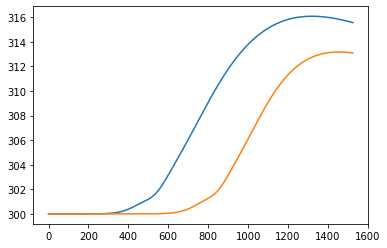

In [77]:
substrate = np.array(substrate)
plt.plot(substrate[:,0])
plt.plot(substrate[:,5])

In [78]:
display = Display(visible=0)
_ = display.start()
active_elements = domain.elements[domain.active_elements].tolist()
active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = domain.nodes.get()
active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
active_grid.point_data['temp'] = heat_solver.temperature.get()
p = pv.Plotter(window_size=(2000,1600))
p.camera_position = ((0, -100, 180),(0, 0, 0),(0.0, 0.0, 1.0))
p.add_mesh(active_grid, show_edges=True, scalars='temp',cmap="coolwarm")
p.show()
p.close()

ViewInteractiveWidget(height=1600, layout=Layout(height='auto', width='100%'), width=2000)